In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [5]:
import datetime
import cPickle as pickle
import csv
import numpy as np
import random
import sys
from file_util import create_folder
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10
    # as long as the OverflowError occurs.
    
    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

In [6]:
name_dataset        = 'news-19_swap_headline'
path_raw_data       = '../data/raw/' + name_dataset + '/'
path_processed_data = '../data/' + name_dataset + '/whole/'

In [7]:
create_folder(path_raw_data)
create_folder(path_processed_data + '/train')
create_folder(path_processed_data + '/dev')
create_folder(path_processed_data + '/test')
create_folder(path_processed_data + '/debug')

# get term-/document-frequency

In [ ]:
csv_reader = csv.reader(open(path_raw_data + 'train.tsv', 'r'), delimiter='\t')

tkn2tf = {}
len_heads = [] #1
len_paras = [] #2
cnt_paras = [] #3
len_bodys = [] #4

# csv data: 0:id, 1:head, 2:body, 3:label

print datetime.datetime.now().isoformat()

for n, row in enumerate(csv_reader):
    if (n+1) % 100000 == 0: print n+1,
    
    head = row[1].lower().strip()
    
    for tkn in head.split():
        if tkn in tkn2tf: tkn2tf[tkn] += 1
        else: tkn2tf[tkn] = 1
    len_heads.append(len(head.split())) #1
    
    body = row[2].lower().strip()
    tkn_para = []
    for para in body.split('<eop>'):
        if para and para != ' ':
            _para = para + '<eop>'
            len_para = len(_para.split())
            len_paras.append(len_para) #2
            tkn_para.append(_para)
    cnt_paras.append(len(tkn_para)) #3
    
    body_split = []
    for tkn in body.split():
        if tkn in tkn2tf: tkn2tf[tkn] += 1
        else: tkn2tf[tkn] = 1
        body_split.append(tkn)
    len_bodys.append(len(body_split)) #4
            
print n+1, 'Done'
print datetime.datetime.now().isoformat()
print 'voca size :', len(tkn2tf)

2020-05-09T11:52:02.551185
100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000

In [46]:
n

4607109

In [47]:
sorted_token = sorted(tkn2tf.items(), key=lambda kv: kv[1], reverse=True)
tkn2idx = {}
for idx, (tkn, _) in tqdm(enumerate(sorted_token)):
    tkn2idx[tkn] = idx + 2
tkn2idx['<UNK>'] = 1
tkn2idx[''] = 0
if len(tkn2idx) == len(tkn2tf)+2:
    print len(tkn2idx), 'No problem'
print 

print 'Show top-10 tkn:'
for tkn, freq in sorted_token[:10]:
    print tkn,':',freq
print ''

6030705it [00:04, 1301747.32it/s]

6030707 No problem

Show top-10 tkn:
the : 149756232
, : 132282352
<eos> : 125113615
. : 110259142
to : 73400422
of : 65310225
<eop> : 64078888
and : 63459485
a : 61726426
in : 53962619



In [48]:
with open(path_processed_data + 'dic_mincut0.txt', 'wb') as f:
    for key in tkn2idx.keys():
        f.write(key+'\n')

In [68]:
tkn2tf_mincut5 = {}
for tkn, tf in tkn2tf.items():
    if tf < 100:
        continue
    tkn2tf_mincut5[tkn] = tf
print 'voca size :', len(tkn2tf_mincut5)

voca size : 186631


In [69]:
tkn2tf_mincut5['<EOS>'] = tkn2tf_mincut5['<eos>']
tkn2tf_mincut5['<EOP>'] = tkn2tf_mincut5['<eop>']

del tkn2tf_mincut5['<eos>']
del tkn2tf_mincut5['<eop>']

In [70]:
import operator
sorted_voca = sorted(tkn2tf_mincut5.items(), key=operator.itemgetter(1))

In [71]:
list_voca_mincut = []
list_voca_mincut.append('')   # PAD
list_voca_mincut.append('<UNK>')   # UNK
list_voca_mincut.append('<EOS>')   # EOS
list_voca_mincut.append('<EOP>')   # EOP

for word, idx in sorted_voca:
    if word=='<UNK>' or word=='<EOP>' or word=='<EOS>':
        print("existing word", word)
        continue
    else:
        list_voca_mincut.append(word)
        
len(list_voca_mincut)

('existing word', '<EOP>')
('existing word', '<EOS>')


186633

In [72]:
with open(path_processed_data + 'dic_mincutN.txt', 'wb') as f:
    for i in range(len(list_voca_mincut)):
        f.write(list_voca_mincut[i]+'\n')

In [73]:
dic_voca = {}
for voca in list_voca_mincut:
    dic_voca[voca] = len(dic_voca)

In [74]:
print(dic_voca[''], dic_voca['<UNK>'], dic_voca['<EOS>'], dic_voca['<EOP>'])

(0, 1, 2, 3)


In [75]:
with open(path_processed_data + 'dic_mincutN.pkl', 'wb') as f:
    pickle.dump(dic_voca, f)

## read voca from dic

In [8]:
list_voca = []
with open(path_processed_data + 'dic_mincutN.txt', 'r') as f:
    list_voca = f.readlines()
    list_voca = [x.strip() for x in list_voca]

dic_voca = {}
for voca in list_voca:
    dic_voca[voca] = len(dic_voca)

## for data processing

In [9]:
import copy
dic_voca_lower = copy.deepcopy(dic_voca)

In [10]:
dic_voca_lower['<eos>'] = dic_voca_lower['<EOS>']
dic_voca_lower['<eop>'] = dic_voca_lower['<EOP>']

del dic_voca_lower['<EOS>']
del dic_voca_lower['<EOP>']

In [11]:
len(dic_voca_lower)

186633

In [12]:
print(dic_voca_lower[''], dic_voca_lower['<UNK>'], dic_voca_lower['<eos>'], dic_voca_lower['<eop>'])

(0, 1, 2, 3)


## stats

In [80]:
import csv
import sys
import numpy as np

data= []
with open(path_raw_data + 'train.tsv', 'r') as f:
    data_csv = csv.reader(f, delimiter='\t')
    for row in data_csv:
        data.append(row)

In [81]:
def print_info(data):
    print("mean", np.average(data))
    print("std", np.std(data))
    print("max", np.max(data))
    print("95.xx coverage", np.average(data) +  2*np.std(data) )
    print("99.73 coverage", np.average(data) +  3*np.std(data) )
    print("99.95 coverage", np.average(data) +  3.5*np.std(data) )
    print("99.99 coverage", np.average(data) +  4*np.std(data) )

In [82]:
head = [x[1].strip() for x in data]
head_len = [len(x.split()) for x in head]
print('head_len')
print_info(head_len)

head_len
('mean', 10.444530302076572)
('std', 3.747475154612142)
('max', 65)
('95.xx coverage', 17.939480611300855)
('99.73 coverage', 21.686955765912998)
('99.95 coverage', 23.560693343219068)
('99.99 coverage', 25.434430920525138)


In [83]:
body = [x[2].strip() for x in data]

In [84]:
body_len = [len(x.split()) for x in body ]
print('body_len')
print_info(body_len)

body_len
('mean', 690.5726433707899)
('std', 472.090307645516)
('max', 27362)
('95.xx coverage', 1634.753258661822)
('99.73 coverage', 2106.843566307338)
('99.95 coverage', 2342.888720130096)
('99.99 coverage', 2578.933873952854)


In [85]:
context_len = [len(x.split('<EOP>')) for x in body]
print('context_len')
print_info(context_len)

context_len
('mean', 14.908695038755315)
('std', 8.101874010378433)
('max', 51)
('95.xx coverage', 31.11244305951218)
('99.73 coverage', 39.21431706989061)
('99.95 coverage', 43.26525407507983)
('99.99 coverage', 47.31619108026905)


In [86]:
body_sentence = []
for sent in body:
    sent = sent.split('<EOP>')
    body_sentence.extend(sent)
body_len = [ len(x.split()) for x in body_sentence ]    
print('body_sentence')
print_info(body_len)

body_sentence
('mean', 45.38720166808962)
('std', 43.027589989589494)
('max', 27074)
('95.xx coverage', 131.4423816472686)
('99.73 coverage', 174.46997163685808)
('99.95 coverage', 195.98376663165283)
('99.99 coverage', 217.49756162644758)


# encode to numpy

In [13]:
def fit_length(data, max_len_t, max_len_b):
    data_t, data_b = data
    
    list_zeros = np.zeros(max_len_b, 'int32').tolist()
    fl_data_t = []
    for datum in data_t:
        try:
            datum = list(datum)
        except:
            pass
        _len = len(datum)
        if _len >= max_len_t:
            fl_data_t.append( datum[:max_len_t] )
        else:
            fl_data_t.append( datum + list_zeros[:(max_len_t-_len)] )
            
    fl_data_b = []
    for datum in data_b:
        try:
            datum = list(datum)
        except:
            pass
        _len = len(datum)
        if _len >= max_len_b:
            fl_data_b.append( datum[:max_len_b] )
        else:
            fl_data_b.append( datum + list_zeros[:(max_len_b-_len)] )
    
    np_data_t = np.asarray(fl_data_t, dtype='int32')
    np_data_b = np.asarray(fl_data_b, dtype='int32')
    
    data = [np_data_t, np_data_b]
    return data

In [38]:
csv_reader = csv.reader(open(path_raw_data + 'train.tsv', 'r'), delimiter='\t')

print datetime.datetime.now().isoformat()
ids = []
heads = []
bodys = []
labels = []
for n, row in enumerate(csv_reader):
    
#     if n <  3000000:
#         continue
    
    if (n+1) % 10000 == 0: print n+1,
    
    ids.append(row[0])
    labels.append(int(row[3]))
    
    head = []
    for tkn in row[1].lower().strip().split():
        if tkn in dic_voca_lower:
            head.append(dic_voca_lower[tkn])
        else:
            head.append(1)
            
    heads.append(head)
    
    body = []
    for tkn in row[2].lower().strip().split():
        if tkn in dic_voca_lower:
            body.append(dic_voca_lower[tkn])
        else:
            body.append(1)
            
    bodys.append(body)
    
print n+1, 'Done'
print datetime.datetime.now().isoformat() # ~5 mins

2020-05-09T23:51:06.002390
3010000 3020000 3030000 3040000 3050000 3060000 3070000 3080000 3090000 3100000 3110000 3120000 3130000 3140000 3150000 3160000 3170000 3180000 3190000 3200000 3210000 3220000 3230000 3240000 3250000 3260000 3270000 3280000 3290000 3300000 3310000 3320000 3330000 3340000 3350000 3360000 3370000 3380000 3390000 3400000 3410000 3420000 3430000 3440000 3450000 3460000 3470000 3480000 3490000 3500000 3510000 3520000 3530000 3540000 3550000 3560000 3570000 3580000 3590000 3600000 3610000 3620000 3630000 3640000 3650000 3660000 3670000 3680000 3690000 3700000 3710000 3720000 3730000 3740000 3750000 3760000 3770000 3780000 3790000 3800000 3810000 3820000 3830000 3840000 3850000 3860000 3870000 3880000 3890000 3900000 3910000 3920000 3930000 3940000 3950000 3960000 3970000 3980000 3990000 4000000 4010000 4020000 4030000 4040000 4050000 4060000 4070000 4080000 4090000 4100000 4110000 4120000 4130000 4140000 4150000 4160000 4170000 4180000 4190000 4200000 4210000 42200

In [39]:
print datetime.datetime.now().isoformat()
[np_heads, np_bodys] = fit_length([heads, bodys], 25, 2100)
print datetime.datetime.now().isoformat() # ~3 mins

2020-05-09T23:57:08.654428
2020-05-10T00:02:24.063221


In [40]:
print datetime.datetime.now().isoformat()
t_trainpath = path_processed_data + '/train/train_title_300-end.npy'
np.save(t_trainpath, np_heads)
b_trainpath = path_processed_data + '/train/train_body_300-end.npy'
np.save(b_trainpath, np_bodys)
l_trainpath = path_processed_data + '/train/train_label_300-end.npy'
np.save(l_trainpath, labels)
print datetime.datetime.now().isoformat()

2020-05-10T00:02:24.087299
2020-05-10T00:03:09.489084


# devset

In [28]:
csv_reader = csv.reader(open(path_raw_data + 'dev.tsv', 'r'), delimiter='\t')

print datetime.datetime.now().isoformat()
ids_dev = []
heads_dev = []
bodys_dev = []
labels_dev = []
for n, row in enumerate(csv_reader):
    if (n+1) % 10000 == 0: print n+1,
    
    ids_dev.append(row[0])
    labels_dev.append(int(row[3]))
    
    head = []
    for tkn in row[1].lower().strip().split():
        if tkn in dic_voca_lower:
            head.append(dic_voca_lower[tkn])
        else:
            head.append(1)
    heads_dev.append(head)
    
    body = []
    for tkn in row[2].lower().strip().split():
        if tkn in dic_voca_lower:
            body.append(dic_voca_lower[tkn])
        else:
            body.append(1)
    bodys_dev.append(body)
    
print n+1, 'Done'
print datetime.datetime.now().isoformat()

2020-05-09T23:34:35.458949
9694 Done
2020-05-09T23:34:37.670537


In [29]:
print datetime.datetime.now().isoformat()
[np_heads_dev, np_bodys_dev] = fit_length([heads_dev, bodys_dev], 25, 2100)
print datetime.datetime.now().isoformat() # ~3 mins

2020-05-09T23:34:48.755332
2020-05-09T23:34:50.238275


In [31]:
print datetime.datetime.now().isoformat()
t_trainpath = path_processed_data + '/dev/dev_title.npy'
np.save(t_trainpath, np_heads_dev)
b_trainpath = path_processed_data + '/dev/dev_body.npy'
np.save(b_trainpath, np_bodys_dev)
l_trainpath = path_processed_data + '/dev/dev_label.npy'
np.save(l_trainpath, labels_dev)
print datetime.datetime.now().isoformat()

2020-05-09T23:35:08.170559
2020-05-09T23:35:08.272466


# testset

In [20]:
csv_reader = csv.reader(open(path_raw_data + '/test.tsv', 'r'), delimiter='\t')

print datetime.datetime.now().isoformat()
ids_dev = []
heads_dev = []
bodys_dev = []
labels_dev = []
for n, row in enumerate(csv_reader):
    if (n+1) % 10000 == 0: print n+1,
    
    ids_dev.append(row[0])
    labels_dev.append(int(row[3]))
    
    head = []
    for tkn in row[1].lower().strip().split():
        if tkn in dic_voca_lower:
            head.append(dic_voca_lower[tkn])
        else:
            head.append(1)
    heads_dev.append(head)
    
    body = []
    for tkn in row[2].lower().strip().split():
        if tkn in dic_voca_lower:
            body.append(dic_voca_lower[tkn])
        else:
            body.append(1)
    bodys_dev.append(body)
    
print n+1, 'Done'
print datetime.datetime.now().isoformat()

2020-05-09T23:32:52.894253
9626 Done
2020-05-09T23:33:21.303511


In [21]:
print datetime.datetime.now().isoformat()
[np_heads_dev, np_bodys_dev] = fit_length([heads_dev, bodys_dev], 25, 2100)
print datetime.datetime.now().isoformat() # ~3 mins

2020-05-09T23:33:21.312804
2020-05-09T23:33:22.601114


In [22]:
print datetime.datetime.now().isoformat()
t_trainpath = path_processed_data + '/test/test_title.npy'
np.save(t_trainpath, np_heads_dev)
b_trainpath = path_processed_data + '/test/test_body.npy'
np.save(b_trainpath, np_bodys_dev)
l_trainpath = path_processed_data + '/test/test_label.npy'
np.save(l_trainpath, labels_dev)
print datetime.datetime.now().isoformat()

2020-05-09T23:33:22.612300
2020-05-09T23:33:22.684770


# debugset

In [23]:
print datetime.datetime.now().isoformat()
t_trainpath = path_processed_data + '/debug/debug_title.npy'
np.save(t_trainpath, np_heads_dev[:200])
b_trainpath = path_processed_data + '/debug/debug_body.npy'
np.save(b_trainpath, np_bodys_dev[:200])
l_trainpath = path_processed_data + '/debug/debug_label.npy'
np.save(l_trainpath, labels_dev[:200])
print datetime.datetime.now().isoformat()

2020-05-09T23:33:22.694492
2020-05-09T23:33:22.993126


In [24]:
with open(path_processed_data + 'dic_mincutN.txt') as f:
    test_list_voca = f.readlines()
    test_list_voca = [x.strip() for x in test_list_voca]

In [25]:
from nlp_vocab import Vocab

In [26]:
tt = Vocab(test_list_voca)

In [27]:
print(tt.index2sent(np_heads_dev[10]))

democrats need to be more democratic                   


## 아래는 아직 진행 안함

# para ver.

In [15]:
SEED = 448
random.seed(SEED)

In [16]:
csv_reader = csv.reader(open('version2/data_para_train.csv', 'r'))

print datetime.datetime.now().isoformat()
data = []
true_data = []
for n, row in enumerate(csv_reader):
    if (n+1) % 100000 == 0: print n+1,
        
    if row[3] == "1":
        data.append(row)
    else:
        true_data.append(row)

random.shuffle(true_data)
data += true_data[:len(data)]

print datetime.datetime.now().isoformat()
ids_para = []
heads_para = []
bodys_para = []
labels_para = []    
for n, row in enumerate(data):
    if (n+1) % 10000 == 0: print n+1,
    
    ids_para.append(row[0])
    labels_para.append(int(row[3]))
    
    head = []
    for tkn in row[1].split():
        if tkn in tkn2idx_mincut5:
            head.append(tkn2idx_mincut5[tkn])
        else:
            head.append(1)
    heads_para.append(head)
    
    body = []
    for tkn in row[2].split():
        if tkn in tkn2idx_mincut5:
            body.append(tkn2idx_mincut5[tkn])
        else:
            body.append(1)
    bodys_para.append(body)
    
print n+1, ': Done'
print datetime.datetime.now().isoformat()
print datetime.datetime.now().isoformat()
[np_heads_para, np_bodys_para] = fit_length([heads_para, bodys_para], 49, 170)
print 'numpy: Done'
print datetime.datetime.now().isoformat() # ~3 mins

print datetime.datetime.now().isoformat()
t_trainpath = 'nps/train_para_head_mincut5'
np.save(t_trainpath, np_heads_para)
b_trainpath = 'nps/train_para_body_mincut5'
np.save(b_trainpath, np_bodys_para)
l_trainpath = 'nps/train_para_label_mincut5'
np.save(l_trainpath, labels_para)
print 'save: Done'
print datetime.datetime.now().isoformat()

2017-12-30T10:40:39.559846
100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 6000000 6100000 6200000 6300000 6400000 6500000 6600000 6700000 6800000 6900000 7000000 7100000 7200000 7300000 7400000 7500000 7600000 7700000 7800000 7900000 8000000 8100000 8200000 8300000 8400000 8500000 8600000 8700000 8800000 8900000 9000000 9100000 9200000 9300000 9400000 9500000 9600000 9700000 9800000 9900000 10000000 10100000 10200000 10300000 10400000 10500000 10600000 10700000 10800000 10900000 11000000 11100000 11200000 11300000 11400000 11500000 11600000 11700000 11800000 11900000 12000000 1

In [4]:
import numpy as np
l_trainpath = np.load('nps/train_para_label_mincut5.npy')

In [5]:
l_trainpath.shape

(4081788,)

In [17]:
csv_reader = csv.reader(open('version2/data_para_dev.csv', 'r'))

print datetime.datetime.now().isoformat()
ids_para_dev = []
heads_para_dev = []
bodys_para_dev = []
labels_para_dev = []
for n, row in enumerate(csv_reader):
    if (n+1) % 10000 == 0: print n+1,
    
    ids_para_dev.append(row[0])
    labels_para_dev.append(int(row[3]))
    
    head = []
    for tkn in row[1].split():
        if tkn in tkn2idx_mincut5:
            head.append(tkn2idx_mincut5[tkn])
        else:
            head.append(1)
    heads_para_dev.append(head)
    
    body = []
    for tkn in row[2].split():
        if tkn in tkn2idx_mincut5:
            body.append(tkn2idx_mincut5[tkn])
        else:
            body.append(1)
    bodys_para_dev.append(body)
    
print n+1, 'Done'
print datetime.datetime.now().isoformat()
print datetime.datetime.now().isoformat()
[np_heads_para_dev, np_bodys_para_dev] = fit_length([heads_para_dev, bodys_para_dev], 49, 170)
print datetime.datetime.now().isoformat() # ~3 mins

print datetime.datetime.now().isoformat()
t_trainpath = 'nps/valid_para_head_mincut5'
np.save(t_trainpath, np_heads_para_dev)
b_trainpath = 'nps/valid_para_body_mincut5'
np.save(b_trainpath, np_bodys_para_dev)
l_trainpath = 'nps/valid_para_label_mincut5'
np.save(l_trainpath, labels_para_dev)
print datetime.datetime.now().isoformat()

2017-12-30T10:45:58.397408
10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000 800000 810000 820000 830000 834064 Done
2017-12-30T10:46:19.560618
2017-12-30T10:46:19.560703
2017-12-30T10:46:47.015257
2017-12-30T10:46:47.015503
2017-12-30T10:46:47.355907


# testset

In [18]:
csv_reader = csv.reader(open('version2/data_whole_test.csv', 'r'))

print datetime.datetime.now().isoformat()
ids_test = []
heads_test = []
bodys_test = []
labels_test = []
for n, row in enumerate(csv_reader):
    if (n+1) % 10000 == 0: print n+1,
    
    ids_test.append(row[0])
    labels_test.append(int(row[3]))
    
    head = []
    for tkn in row[1].split():
        if tkn in tkn2idx_mincut5:
            head.append(tkn2idx_mincut5[tkn])
        else:
            head.append(1)
    heads_test.append(head)
    
    body = []
    for tkn in row[2].split():
        if tkn in tkn2idx_mincut5:
            body.append(tkn2idx_mincut5[tkn])
        else:
            body.append(1)
    bodys_test.append(body)
    
print n+1, 'Done'
print datetime.datetime.now().isoformat()

2017-12-30T10:46:47.369600
10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 100000 Done
2017-12-30T10:47:11.911809


In [19]:
print datetime.datetime.now().isoformat()
[np_heads_test, np_bodys_test] = fit_length([heads_test, bodys_test], 49, 1200)
print datetime.datetime.now().isoformat() # ~3 mins

2017-12-30T10:47:11.916242
2017-12-30T10:47:19.225545


In [20]:
print datetime.datetime.now().isoformat()
t_trainpath = 'nps/test_whole_head_mincut5'
np.save(t_trainpath, np_heads_test)
b_trainpath = 'nps/test_whole_body_mincut5'
np.save(b_trainpath, np_bodys_test)
l_trainpath = 'nps/test_whole_label_mincut5'
np.save(l_trainpath, labels_test)
print datetime.datetime.now().isoformat()

2017-12-30T10:47:19.237108
2017-12-30T10:47:19.522220


# test stats.

In [22]:
csv_reader = csv.reader(open('version2/data_whole_test.csv', 'r'))

len_heads_test = [] #1
len_paras_test = [] #2
cnt_paras_test = [] #3
len_bodys_test = [] #4

labels_test = []
print datetime.datetime.now().isoformat()
for n, row in enumerate(csv_reader):
    if (n+1) % 100000 == 0: print n+1,
        
    labels_test.append(int(row[3]))
    
    head = row[1]
    len_heads_test.append(len(head.split())) #1
    
    body = row[2]
    tkn_para = []
    for para in body.split('<EOP>'):
        if para and para != ' ':
            _para = para + '<EOP>'
            len_para = len(_para.split())
            len_paras_test.append(len_para) #2
            tkn_para.append(_para)
    cnt_paras_test.append(len(tkn_para)) #3
    
    body_split = body.split()
    len_bodys_test.append(len(body_split)) #4
            
print n+1, 'Done'
print datetime.datetime.now().isoformat()

2017-12-29T18:45:21.058702
100000 100000 Done
2017-12-29T18:45:31.269345


In [23]:
#1
len_titles = np.array(len_heads_test)
print len_titles.tolist().count(1)
print np.max(len_titles), np.min(len_titles), np.mean(len_titles), np.std(len_titles)
len_t = len(len_titles)
cnt_t = sum(len_titles <= 49)
print cnt_t, len_t, cnt_t*1.0/len_t

0
38 3 13.55746 3.13595573126
100000 100000 1.0


In [27]:
#2
len_paras = np.array(len_paras_test)
print len_paras.tolist().count(1)
print np.max(len_paras), np.min(len_paras), np.mean(len_paras), np.std(len_paras)
len_p = len(len_paras)
cnt_p = sum(len_paras <= 170)
print cnt_p, len_p, cnt_p*1.0/len_p

0
4127 3 82.7307296744 121.078232278
892558 968432 0.921652733491


In [25]:
#3
cnt_para = np.array(cnt_paras_test)
print cnt_para.tolist().count(1)
print np.max(cnt_para), np.min(cnt_para), np.mean(cnt_para), np.std(cnt_para), np.median(cnt_para)
len_cp = len(cnt_para)
cnt_cp = sum(cnt_para <= 20)
print cnt_cp, len_cp, cnt_cp*1.0/len_cp

7132
104 1 9.68432 7.30949698253 9.0
92534 100000 0.92534


In [28]:
#4
len_bodys = np.array(len_bodys_test)
print len_bodys.tolist().count(2)
print np.max(len_bodys), np.min(len_bodys), np.mean(len_bodys), np.std(len_bodys)
len_b = len(len_bodys)
cnt_b = sum(len_bodys <= 1200)
print cnt_b, len_b, cnt_b*1.0/len_b

0
5208 403 801.19086 313.270892795
90124 100000 0.90124


(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.08000000e+02,   0.00000000e+00,
          9.15000000e+02,   0.00000000e+00,   5.29000000e+02,
          0.00000000e+00,   6.51000000e+02,   0.00000000e+00,
          6.94000000e+02,   0.00000000e+00,   1.41300000e+03,
          0.00000000e+00,   2.64000000e+03,   0.00000000e+00,
          2.94600000e+03,   0.00000000e+00,   2.64700000e+03,
          0.00000000e+00,   2.76400000e+03,   0.00000000e+00,
          2.91400000e+03,   0.00000000e+00,   3.23700000e+03,
          0.00000000e+00,   3.72500000e+03,   0.00000000e+00,
          4.28300000e+03,   0.00000000e+00,   4.86300000e+03,
          0.00000000e+00,   5.38000000e+03,   0.00000000e+00,
          6.25800000e+03,   0.00000000e+00,   6.73800000e+03,
          0.00000000e+00,   7.40700000e+03,   0.00000000e+00,
          8.14300000e+03,   0.00000000e+00,   8.76500000e+03,
          0.00000000e+00,   9.17000000e+03,   0.00000000e+00,
        

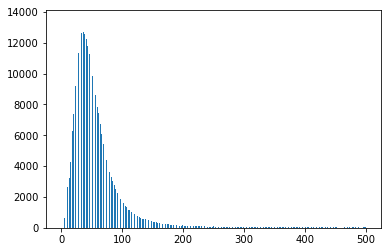

In [57]:
plt.figure(1)
plt.hist(len_paras, range=[0, 500], normed=False, bins=500)

In [17]:
tkn2df = {}
for tkn in tkn2tf.keys():
    tkn2df[tkn] = 0
    
csv_reader = csv.reader(open('final_final/data_whole_training.csv', 'r'))

print datetime.datetime.now().isoformat()
for n, row in enumerate(csv_reader):
    if (n+1) % 100000 == 0: print n+1,

    tmp_tkn = []
    head = row[1]
    body = row[2]
    doc = ' '.join([head, body])
    for tkn in doc.split():
        if tkn in tmp_tkn:
            continue
        else:
            tkn2df[tkn] += 1
            tmp_tkn.append(tkn)

print n, 'Done'
print datetime.datetime.now().isoformat()

2017-12-27T17:06:43.990426
100000 200000 300000 400000 500000

KeyboardInterrupt: 